<a href="https://colab.research.google.com/github/babi00/ai4biological-pattern/blob/main/download_and_analyze_from_iNaturalist/annotate_unnotated_data_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modello che utilizza multi binary classes, ResNet come extractor embedding e semplice classificatore
(Download delle immagini in locale)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import requests
from io import BytesIO
from google.colab import drive
import time

torch.manual_seed(42)
np.random.seed(42)

!apt-get install git

# Clone the repository without checking out files
!git clone --filter=blob:none --no-checkout https://github.com/babi00/ai4biological-pattern.git
%cd ai4biological-pattern

# Enable sparse checkout
!git sparse-checkout init --cone



drive.mount('/content/drive')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Cloning into 'ai4biological-pattern'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 126 (delta 3), reused 8 (delta 3), pack-reused 117 (from 2)
Receiving objects: 100% (126/126), 14.69 MiB | 10.75 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/ai4biological-pattern
Mounted at /content/drive


In [2]:
#1.Load and prepare data
class PlantPhenologyDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

        #possible phenology states
        self.phenology_classes = [
            'Flowering',
            'No Evidence of Flowering',
            'Flower Budding',
            'Fruiting'
        ]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
      row = self.dataframe.iloc[idx]
      obs_id = row['observation_id']

      #try to load images: they can have multiple formats
      variants = [f"{obs_id}_1.jpeg", f"{obs_id}_1.jpg", f"{obs_id}_1.JPG", f"{obs_id}_1.png", f"{obs_id}_1.PNG", f"{obs_id}_0.jpeg", f"{obs_id}_0.jpg", f"{obs_id}_0.JPG", f"{obs_id}_0.png", f"{obs_id}_0.PNG", f"{obs_id}_2.jpg", f"{obs_id}_2.jpeg"]

      image = None

      for filename in variants:
          local_path = os.path.join(self.img_dir, filename) #locally downloaded
          if os.path.exists(local_path):
              try:
                  image = Image.open(local_path).convert("RGB")
                  break
              except Exception as e:
                  print(f"Failed to open image {filename}: {e}")
              except:
                  continue

      if image is None:
          raise FileNotFoundError(f"Could not load any image for observation ID {obs_id}")

      if self.transform:
          image = self.transform(image)

      #one-hot encoded label vector for binary classifications
      label_vector = torch.zeros(len(self.phenology_classes))
      if pd.notna(row['value']):
          for i, phenology_class in enumerate(self.phenology_classes):
              #if this is the correct class, set to 1
              if row['value'] == phenology_class:
                  label_vector[i] = 1

      return image, label_vector, obs_id

#Data loading function for a single specie
def load_data_single_specie(csv_path, img_dir):
    df = pd.read_csv(csv_path)

    #Split into labeled and unlabeled data
    labeled_df = df[df['value'].notna()].copy()
    unlabeled_df = df[df['value'].isna()].copy()

    print(f"Total observations: {len(df)}")
    print(f"Labeled observations: {len(labeled_df)}")
    print(f"Unlabeled observations: {len(unlabeled_df)}")

    #Split labeled data into train and validation sets
    train_df, val_df = train_test_split(labeled_df, test_size=0.2, random_state=42, stratify=labeled_df['value'])

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")

    #Define transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    #datasets
    train_dataset = PlantPhenologyDataset(train_df, img_dir, transform=train_transform)
    val_dataset = PlantPhenologyDataset(val_df, img_dir, transform=val_transform)
    unlabeled_dataset = PlantPhenologyDataset(unlabeled_df, img_dir, transform=val_transform)

    #dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16)

    return train_loader, val_loader, unlabeled_loader, train_dataset.phenology_classes

In [3]:
#2.Define the embedding extractor: ResNet without the last FC layer
def get_resnet_embeddings_extractor_model(num_classes):
    #Use a pre-trained ResNet18 model
    model = models.resnet18(weights='IMAGENET1K_V1')

    #Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    embeddings_extractor= nn.Sequential(*list(model.children())[:-1]) #removes the last FC layer

    return embeddings_extractor

In [4]:
#3.Extract embeddings using the embeddings_extractor and create the DataLoader
def extract_embeddings(dataloader, embeddings_extractor, device):
    embeddings_extractor.eval()
    all_embeddings = []
    all_labels = []
    all_ids = []

    with torch.no_grad():
        for images, labels, obs_id in dataloader:
            images = images.to(device)
            embeddings = embeddings_extractor(images).view(images.size(0), -1)
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)
            all_ids.extend(obs_id)

    embeddings_tensors = torch.cat(all_embeddings, dim=0).to(device)
    labels_tensors = torch.cat(all_labels, dim=0).to(device)
    obs_id_tensor = torch.tensor(all_ids).to(device)


    dataset = torch.utils.data.TensorDataset(embeddings_tensors, labels_tensors, obs_id_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    embedding_size = embeddings_tensors.shape[1] #useful for classifier

    return loader, embedding_size

In [5]:
#4.Construct a classifier that given the embedding it predicts the phenology state
class PhenologyClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_classes=4):
        super().__init__()
        self.classifier = nn.Sequential(
              nn.Linear(input_dim, hidden_dim),
              nn.ReLU(),
              nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [6]:
#5. Training function
def train_classifier(classifier, train_loader, val_loader, criterion, optimizer, device, folder_name, phenology_classes, num_epochs=10, lr=0.001):
    classifier.to(device)
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc_per_class': [], 'val_acc_per_class': [], 'train_acc': [],'val_acc': []}
    num_classes = len(phenology_classes)

    for epoch in range(num_epochs):
        classifier.train()
        running_loss = 0.0
        correct = torch.zeros(num_classes).to(device)
        total = torch.zeros(num_classes).to(device)

        for embeddings, labels, _ in train_loader:
            #zero the parameter gradients
            optimizer.zero_grad()

            #forward pass
            outputs = classifier(embeddings)
            loss = criterion(outputs, labels.float())

            #backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * embeddings.size(0)

            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
            top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
            preds[range(probs.size(0)), top_class] = 1
            correct += (preds == labels).sum(dim=0)
            total += labels.size(0)


        #track statistics to draw graph
        epoch_train_loss = running_loss / total.sum().item()
        epoch_train_acc_per_class = (correct / total).cpu().numpy()
        epoch_train_acc = correct.sum().item() / total.sum().item()
        epoch_val_acc = correct.sum().item() / total.sum().item()
        history['train_loss'].append(epoch_train_loss)
        history['train_acc_per_class'].append(epoch_train_acc_per_class)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        #validation phase
        classifier.eval()
        running_loss = 0.0
        correct = torch.zeros(num_classes).to(device)
        total = torch.zeros(num_classes).to(device)

        with torch.no_grad():
            for embeddings, labels, _ in val_loader:
                outputs = classifier(embeddings)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * embeddings.size(0)

                probs = torch.sigmoid(outputs)
                preds = torch.zeros_like(probs)
                top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
                preds[range(probs.size(0)), top_class] = 1
                correct += (preds == labels).sum(dim=0)
                total += labels.size(0)

        #track statistics to draw graph
        epoch_val_loss = running_loss / total.sum().item()
        epoch_val_acc_per_class = (correct / total).cpu().numpy()
        history['val_loss'].append(epoch_val_loss)
        history['val_acc_per_class'].append(epoch_val_acc_per_class)

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Validation Loss: {epoch_val_loss:.4f}')

    torch.save(classifier.state_dict(), f'{folder_name}.pth')
    google_drive_path = f'/content/drive/MyDrive/TESI - PoliTO/phenology_models/{folder_name}.pth'
    torch.save(classifier.state_dict(), google_drive_path)
    classifier.load_state_dict(torch.load(f'{folder_name}.pth'))
    return classifier, history

In [7]:
#6. Evaluate the model
def evaluate_classifier(classifier, dataloader, device, phenology_classes, folder_name):
    classifier.eval()
    all_preds = []
    all_labels = []
    all_ids = []

    with torch.no_grad():
        for embeddings, labels, obs_ids in dataloader:
            outputs = classifier(embeddings)
            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
            top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
            preds[range(probs.size(0)), top_class] = 1

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_ids.extend(obs_ids.cpu())



    #confusion matrix
    all_preds = torch.cat(all_preds, dim=0).cpu().numpy().astype(int)
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy().astype(int)

    print(classification_report(all_labels, all_preds, target_names=phenology_classes))

    cm = multilabel_confusion_matrix(all_labels, all_preds)
    class_names = phenology_classes

    n_classes = len(class_names)
    cols = 2
    rows = (n_classes + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()

    for i in range(n_classes):
        ax = axes[i]
        cmat = cm[i]
        im = ax.imshow(cmat, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f'"{class_names[i]}"')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Not Present', 'Present'])
        ax.set_yticklabels(['Not Present', 'Present'])
        ax.set_ylabel('True')
        ax.set_xlabel('Predicted')

        thresh = cmat.max() / 2
        for j in range(2):
            for k in range(2):
                ax.text(k, j, format(cmat[j, k], 'd'),
                        ha="center", va="center",
                        color="white" if cmat[j, k] > thresh else "black")

    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f'all_confusion_matrices_{folder_name}.png')
    plt.show()


    #Create a DataFrame with results
    results_df = pd.DataFrame({
        'observation_id': all_ids,
        'true_phenology': [phenology_classes[i] for i in np.argmax(all_labels, axis=1)],
        'predicted_phenology': [phenology_classes[i] for i in np.argmax(all_preds, axis=1)]
    })

    return results_df

In [8]:
#7. Make predictions on unlabeled data
def predict_unlabeled(classifier, dataloader, device, phenology_classes):
    classifier.eval()
    all_preds = []
    all_ids = []

    with torch.no_grad():
        for embeddings, labels, obs_ids in dataloader:
            outputs = classifier(embeddings)
            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
            top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
            preds[range(probs.size(0)), top_class] = 1

            all_preds.extend(preds.cpu())
            all_ids.extend(obs_ids.cpu())

    #Create a DataFrame with predictions
    predictions_df = pd.DataFrame({
        'observation_id': all_ids,
        'predicted_phenology': [phenology_classes[np.argmax(pred)] for pred in all_preds]
    })

    return predictions_df

Using device: cuda
Total observations: 10487
Labeled observations: 781
Unlabeled observations: 9706
Training set size: 624
Validation set size: 157
Epoch 1/15: Train Loss: 0.1202, Validation Loss: 0.1025
Epoch 2/15: Train Loss: 0.0947, Validation Loss: 0.0886
Epoch 3/15: Train Loss: 0.0853, Validation Loss: 0.0837
Epoch 4/15: Train Loss: 0.0767, Validation Loss: 0.0812
Epoch 5/15: Train Loss: 0.0726, Validation Loss: 0.0815
Epoch 6/15: Train Loss: 0.0697, Validation Loss: 0.0781
Epoch 7/15: Train Loss: 0.0654, Validation Loss: 0.0812
Epoch 8/15: Train Loss: 0.0628, Validation Loss: 0.0792
Epoch 9/15: Train Loss: 0.0601, Validation Loss: 0.0803
Epoch 10/15: Train Loss: 0.0582, Validation Loss: 0.0841
Epoch 11/15: Train Loss: 0.0589, Validation Loss: 0.0830
Epoch 12/15: Train Loss: 0.0524, Validation Loss: 0.0847
Epoch 13/15: Train Loss: 0.0502, Validation Loss: 0.0852
Epoch 14/15: Train Loss: 0.0495, Validation Loss: 0.0834
Epoch 15/15: Train Loss: 0.0480, Validation Loss: 0.0944


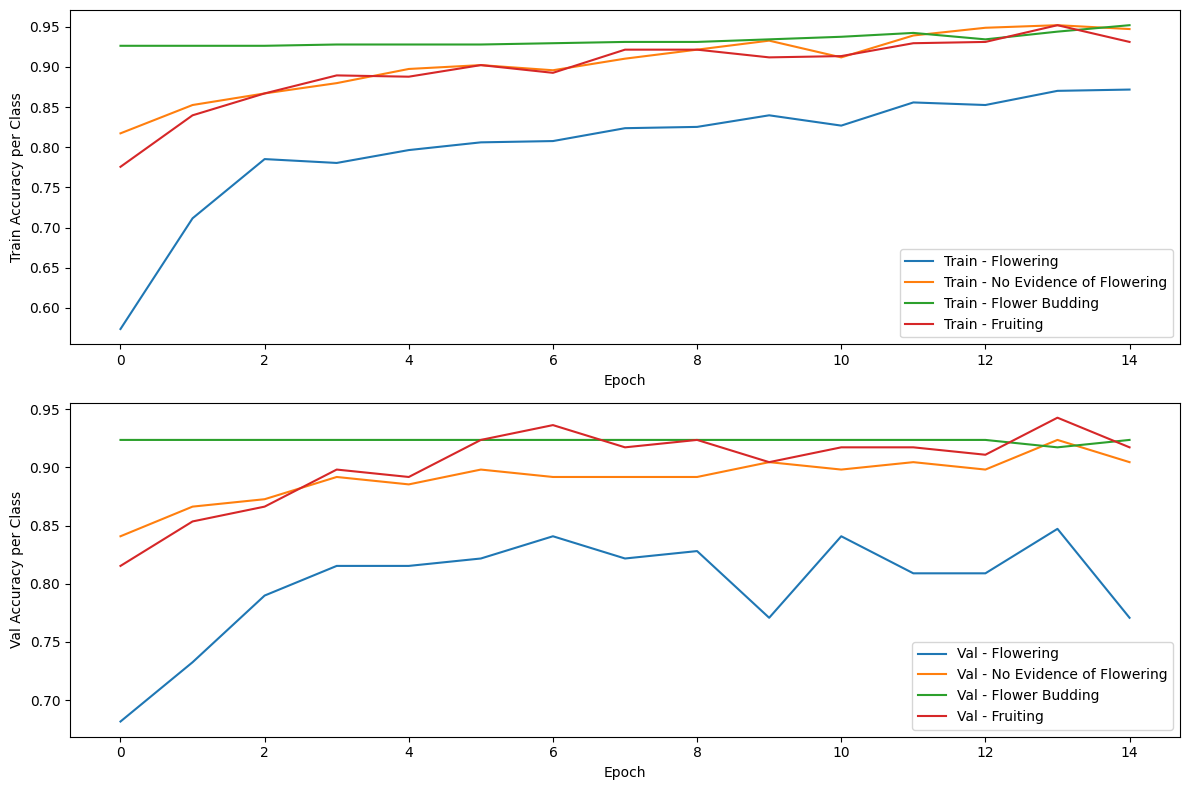

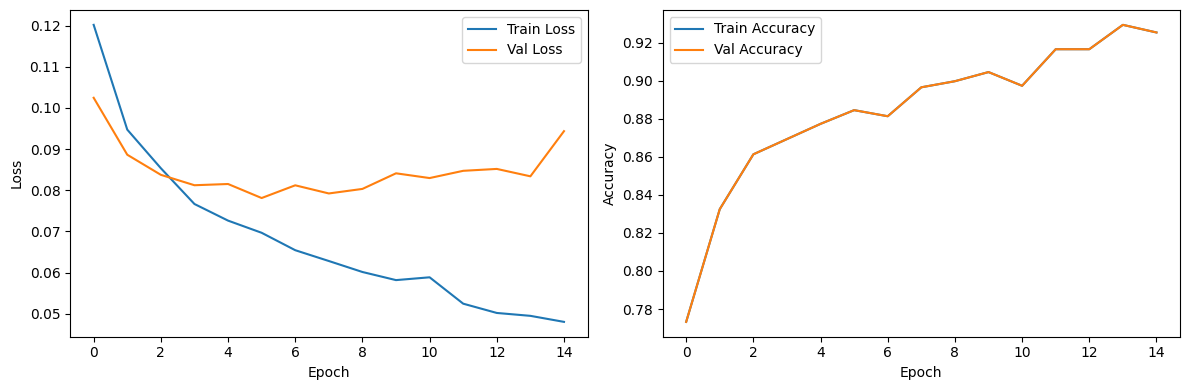

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

               Flowering       0.69      0.97      0.81        78
No Evidence of Flowering       0.82      0.54      0.65        26
          Flower Budding       0.00      0.00      0.00        12
                Fruiting       0.97      0.71      0.82        41

               micro avg       0.76      0.76      0.76       157
               macro avg       0.62      0.56      0.57       157
            weighted avg       0.73      0.76      0.72       157
             samples avg       0.76      0.76      0.76       157



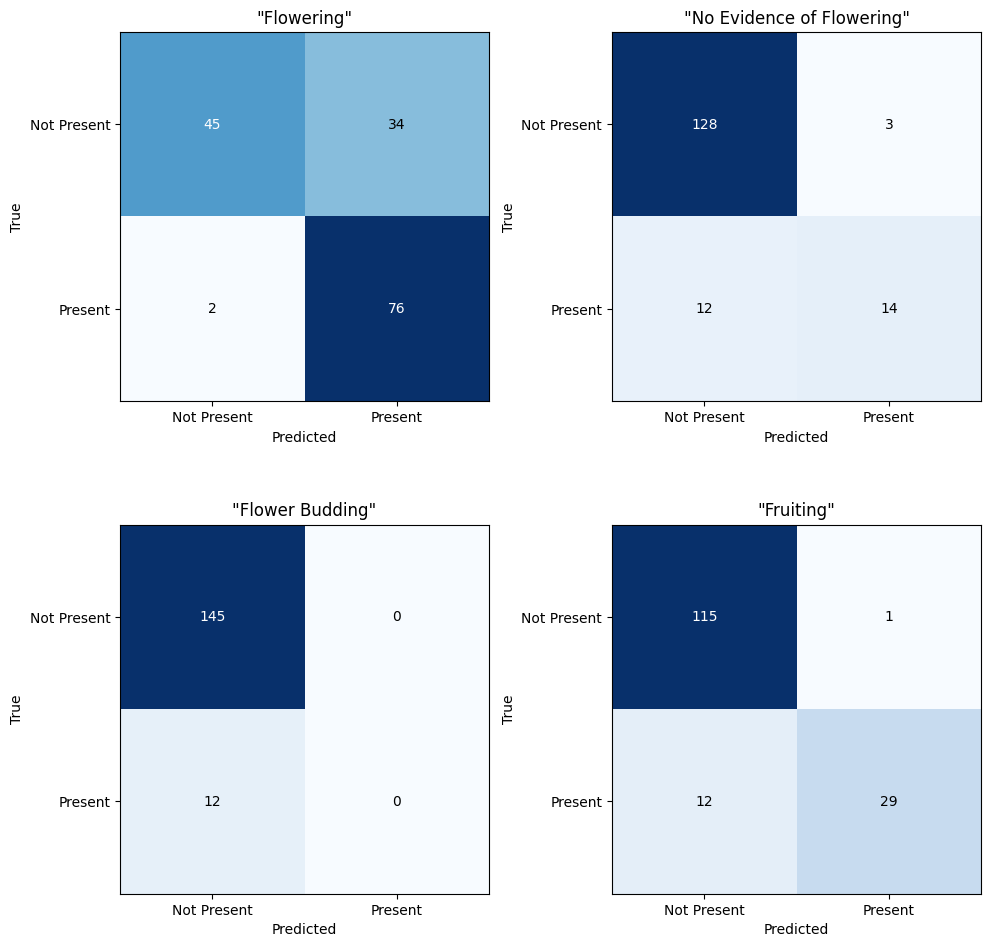

Successfully updated phenology data!


In [ ]:
folder_name='PROVA_fragola_verde'
#to download from github
#github_repository = 'https://raw.githubusercontent.com/babi00/ai4biological-pattern/download_and_analyze_iNaturalist/download_and_analyze_from_iNaturalist/PROVA_fragola_verde/'
#to retrieve from locally downloaded repository
github = '/content/ai4biological-pattern/download_and_analyze_from_iNaturalist'
github_repository = f'{github}/{folder_name}/'
csv_path = f'{github_repository}annotations_detailed_{folder_name}.csv'
img_dir = f'{github_repository}inat_photos/'

if not os.path.isdir(github_repository): #check if data has already been downloaded
    !git sparse-checkout set download_and_analyze_from_iNaturalist/{folder_name}
    !git checkout main

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#Load data
resnet_train_loader, resnet_val_loader, resnet_unlabeled_loader, phenology_classes = load_data_single_specie(csv_path, img_dir)

#embedding extractor model
embeddings_extractor = get_resnet_embeddings_extractor_model(num_classes=len(phenology_classes))
embeddings_extractor = embeddings_extractor.to(device)

#extract embeddings and save in dataloaders
embeddings_train_loader, input_size = extract_embeddings(resnet_train_loader, embeddings_extractor, device)
embeddings_val_loader, _ = extract_embeddings(resnet_val_loader, embeddings_extractor, device)
embeddings_unlabeled_loader, _ = extract_embeddings(resnet_unlabeled_loader, embeddings_extractor, device)

#initialize classifier
classifier = PhenologyClassifier(input_size)

#Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() #for multiple binary classification
optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=0.001) #make sure than the optimizer does not modify all layers: only those earlier specified (not freezed)

#Train model
classifier, history = train_classifier(classifier, embeddings_train_loader, embeddings_val_loader, criterion, optimizer, device, folder_name, phenology_classes, num_epochs=15)

# Plot training history for accuracy per class
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
for i in range(len(phenology_classes)):
    acc = [epoch[i] for epoch in history['train_acc_per_class']]
    plt.plot(acc, label=f'Train - {phenology_classes[i]}')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy per Class')
plt.legend()

plt.subplot(2, 1, 2)
for i in range(len(phenology_classes)):
    acc = [epoch[i] for epoch in history['val_acc_per_class']]
    plt.plot(acc, label=f'Val - {phenology_classes[i]}')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy per Class')
plt.legend()

plt.tight_layout()
plt.savefig(f'training_accuracy_per_class_{folder_name}.png')
plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(f'training_history_{folder_name}.png')
plt.show()

#Evaluate model on validation set
results_df = evaluate_classifier(classifier, embeddings_val_loader, device, phenology_classes, folder_name)
results_df.to_csv(f'validation_results_{folder_name}.csv', index=False)

#Make predictions on unlabeled data
predictions_df = predict_unlabeled(classifier, embeddings_unlabeled_loader, device, phenology_classes)
predictions_df.to_csv(f'unlabeled_predictions_{folder_name}.csv', index=False)

#Merge predictions with original CSV
original_df = pd.read_csv(csv_path)

#Only update rows where Plant Phenology value is missing
mask = (original_df['term'] == 'Plant Phenology') & (original_df['value'].isna())

#Create a dictionary mapping observation_id to predicted phenology
pred_dict = dict(zip(predictions_df['observation_id'], predictions_df['predicted_phenology']))

#Update and save original DataFrame
original_df.loc[mask, 'value'] = original_df.loc[mask, 'observation_id'].map(pred_dict)

original_df.to_csv(f'updated_data_{folder_name}.csv', index=False)
google_drive_path = f'/content/drive/MyDrive/TESI - PoliTO/updated_data_{folder_name}.csv'
original_df.to_csv(google_drive_path, index=False)

print("Successfully updated phenology data!")

In [9]:
def create_model_and_predict(folder_name):

    start_time = time.time()


    #to download from github
    #github_repository = 'https://raw.githubusercontent.com/babi00/ai4biological-pattern/download_and_analyze_iNaturalist/download_and_analyze_from_iNaturalist/PROVA_fragola_verde/'
    #to retrieve from locally downloaded repository
    github = '/content/ai4biological-pattern/download_and_analyze_from_iNaturalist'
    github_repository = f'{github}/{folder_name}/'
    csv_path = f'{github_repository}annotations_detailed_{folder_name}.csv'
    img_dir = f'{github_repository}inat_photos/'

    if not os.path.isdir(github_repository): #check if data has already been downloaded
        print("Download data from github...")
        !git sparse-checkout set download_and_analyze_from_iNaturalist/{folder_name}
        !git checkout main

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    #Load data
    resnet_train_loader, resnet_val_loader, resnet_unlabeled_loader, phenology_classes = load_data_single_specie(csv_path, img_dir)

    #embedding extractor model
    embeddings_extractor = get_resnet_embeddings_extractor_model(num_classes=len(phenology_classes))
    embeddings_extractor = embeddings_extractor.to(device)

    #extract embeddings and save in dataloaders
    embeddings_train_loader, input_size = extract_embeddings(resnet_train_loader, embeddings_extractor, device)
    embeddings_val_loader, _ = extract_embeddings(resnet_val_loader, embeddings_extractor, device)
    embeddings_unlabeled_loader, _ = extract_embeddings(resnet_unlabeled_loader, embeddings_extractor, device)

    #initialize classifier
    classifier = PhenologyClassifier(input_size)

    #Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss() #for multiple binary classification
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=0.001) #make sure than the optimizer does not modify all layers: only those earlier specified (not freezed)

    #Train model
    classifier, history = train_classifier(classifier, embeddings_train_loader, embeddings_val_loader, criterion, optimizer, device, folder_name, phenology_classes, num_epochs=15)

    # Plot training history for accuracy per class
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    for i in range(len(phenology_classes)):
        acc = [epoch[i] for epoch in history['train_acc_per_class']]
        plt.plot(acc, label=f'Train - {phenology_classes[i]}')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy per Class')
    plt.legend()

    plt.subplot(2, 1, 2)
    for i in range(len(phenology_classes)):
        acc = [epoch[i] for epoch in history['val_acc_per_class']]
        plt.plot(acc, label=f'Val - {phenology_classes[i]}')
    plt.xlabel('Epoch')
    plt.ylabel('Val Accuracy per Class')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'training_accuracy_per_class_{folder_name}.png')
    plt.show()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'training_history_{folder_name}.png')
    plt.show()

    #Evaluate model on validation set
    results_df = evaluate_classifier(classifier, embeddings_val_loader, device, phenology_classes, folder_name)
    results_df.to_csv(f'validation_results_{folder_name}.csv', index=False)

    #Make predictions on unlabeled data
    predictions_df = predict_unlabeled(classifier, embeddings_unlabeled_loader, device, phenology_classes)
    predictions_df.to_csv(f'unlabeled_predictions_{folder_name}.csv', index=False)

    #Merge predictions with original CSV
    original_df = pd.read_csv(csv_path)

    #Only update rows where Plant Phenology value is missing
    mask = (original_df['term'] == 'Plant Phenology') & (original_df['value'].isna())

    #Create a dictionary mapping observation_id to predicted phenology
    pred_dict = dict(zip(predictions_df['observation_id'], predictions_df['predicted_phenology']))

    #Update and save original DataFrame
    original_df.loc[mask, 'value'] = original_df.loc[mask, 'observation_id'].map(pred_dict)

    original_df.to_csv(f'updated_data_{folder_name}.csv', index=False)
    google_drive_path = f'/content/drive/MyDrive/TESI - PoliTO/updated_data_{folder_name}.csv'
    original_df.to_csv(google_drive_path, index=False)

    print("Successfully updated phenology data!")

    end_time = time.time()
    print(f"Total process time:{end_time-start_time:.2f} seconds")

Download data from github...
remote: Enumerating objects: 15646, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 15646 (delta 56), reused 0 (delta 0), pack-reused 15583 (from 1)
Receiving objects: 100% (15646/15646), 100.53 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Updating files: 100% (15676/15676), done.
Already on 'main'
Your branch is up to date with 'origin/main'.
Using device: cuda
Total observations: 10487
Labeled observations: 781
Unlabeled observations: 9706
Training set size: 624
Validation set size: 157


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


Epoch 1/15: Train Loss: 0.1241, Validation Loss: 0.1075
Epoch 2/15: Train Loss: 0.0976, Validation Loss: 0.0905
Epoch 3/15: Train Loss: 0.0849, Validation Loss: 0.0843
Epoch 4/15: Train Loss: 0.0791, Validation Loss: 0.0837
Epoch 5/15: Train Loss: 0.0760, Validation Loss: 0.0836
Epoch 6/15: Train Loss: 0.0698, Validation Loss: 0.0826
Epoch 7/15: Train Loss: 0.0675, Validation Loss: 0.0842
Epoch 8/15: Train Loss: 0.0697, Validation Loss: 0.0832
Epoch 9/15: Train Loss: 0.0678, Validation Loss: 0.0823
Epoch 10/15: Train Loss: 0.0615, Validation Loss: 0.0834
Epoch 11/15: Train Loss: 0.0562, Validation Loss: 0.0839
Epoch 12/15: Train Loss: 0.0550, Validation Loss: 0.0853
Epoch 13/15: Train Loss: 0.0556, Validation Loss: 0.0884
Epoch 14/15: Train Loss: 0.0517, Validation Loss: 0.0941
Epoch 15/15: Train Loss: 0.0508, Validation Loss: 0.0875


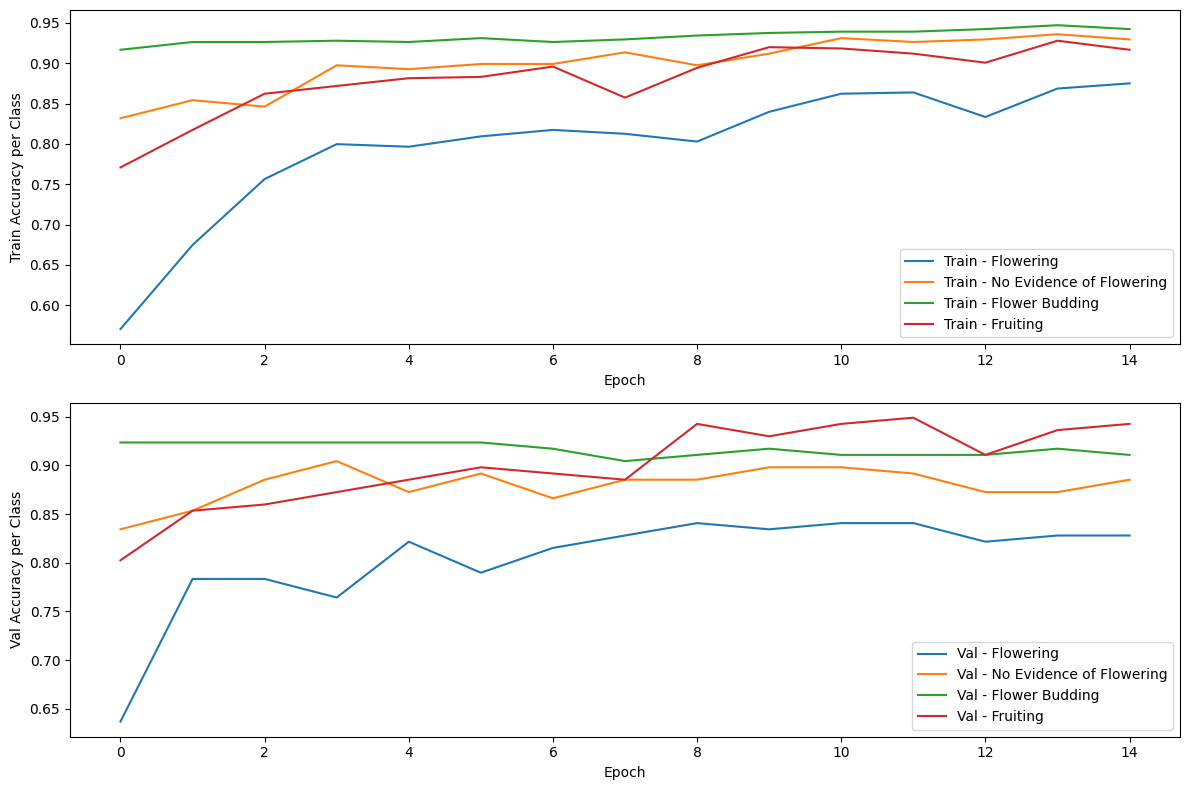

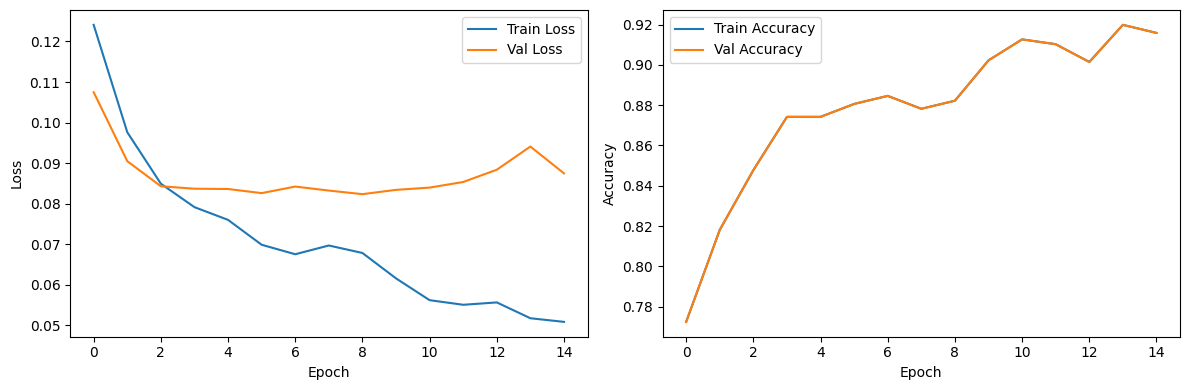

                          precision    recall  f1-score   support

               Flowering       0.80      0.87      0.83        78
No Evidence of Flowering       0.62      0.81      0.70        26
          Flower Budding       0.00      0.00      0.00        12
                Fruiting       0.94      0.83      0.88        41

               micro avg       0.78      0.78      0.78       157
               macro avg       0.59      0.63      0.60       157
            weighted avg       0.75      0.78      0.76       157
             samples avg       0.78      0.78      0.78       157



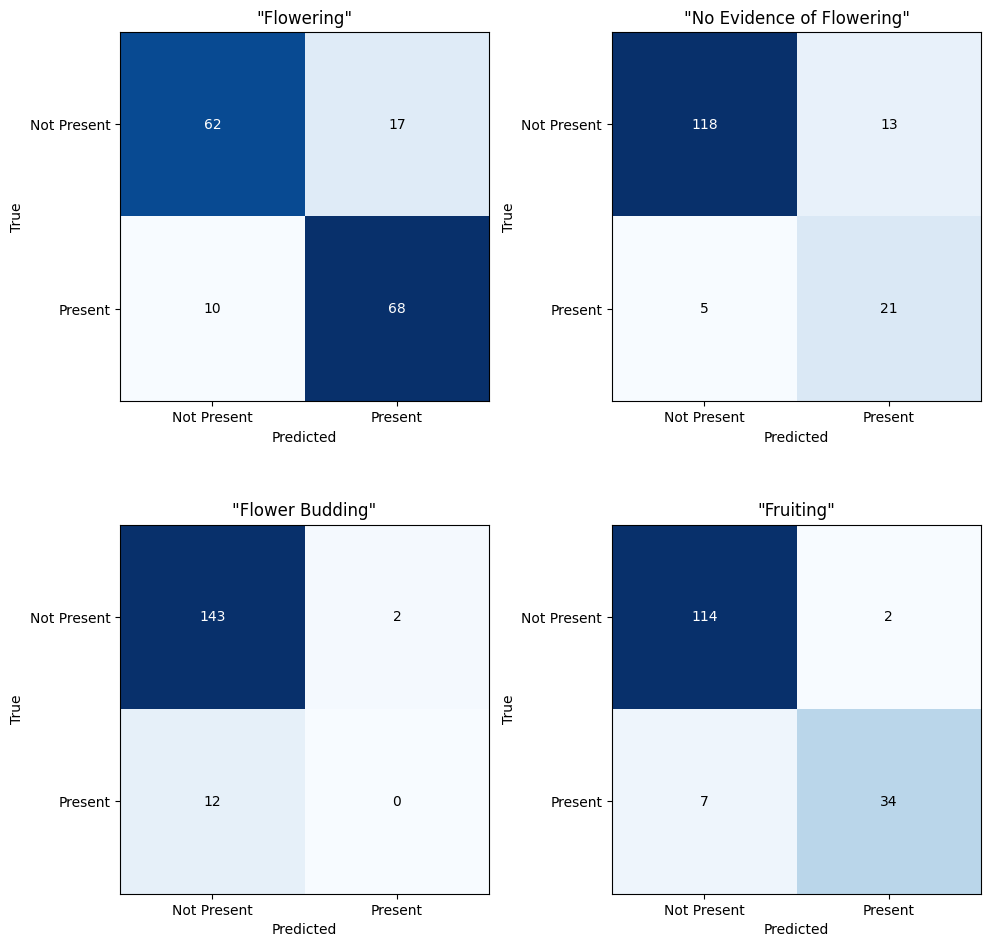

Successfully updated phenology data!
Total process time:46.26 seconds


In [10]:
create_model_and_predict('PROVA_fragola_verde')

In [10]:
create_model_and_predict('complete_achillea_millefoglie_n_a')

Download data from github...
remote: Enumerating objects: 163772, done.
remote: Counting objects: 100% (490/490), done.
remote: Compressing objects: 100% (458/458), done.
remote: Total 163772 (delta 470), reused 33 (delta 32), pack-reused 163282 (from 1)
Receiving objects: 100% (163772/163772), 997.11 MiB | 32.43 MiB/s, done.
Resolving deltas: 100% (695/695), done.
Updating files: 100% (164237/164237), done.
Already on 'main'
Your branch is up to date with 'origin/main'.
Using device: cuda
Total observations: 124622
Labeled observations: 12140
Unlabeled observations: 112482
Training set size: 9712
Validation set size: 2428


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


FileNotFoundError: Could not load any image for observation ID 232209842

Using device: cuda
Total observations: 22397
Labeled observations: 8246
Unlabeled observations: 14151
Training set size: 6596
Validation set size: 1650
Epoch 1/15: Train Loss: 0.0941, Validation Loss: 0.0832
Epoch 2/15: Train Loss: 0.0831, Validation Loss: 0.0835
Epoch 3/15: Train Loss: 0.0787, Validation Loss: 0.0796
Epoch 4/15: Train Loss: 0.0775, Validation Loss: 0.0780
Epoch 5/15: Train Loss: 0.0744, Validation Loss: 0.0750
Epoch 6/15: Train Loss: 0.0717, Validation Loss: 0.0746
Epoch 7/15: Train Loss: 0.0711, Validation Loss: 0.0754
Epoch 8/15: Train Loss: 0.0699, Validation Loss: 0.0754
Epoch 9/15: Train Loss: 0.0675, Validation Loss: 0.0749
Epoch 10/15: Train Loss: 0.0651, Validation Loss: 0.0770
Epoch 11/15: Train Loss: 0.0645, Validation Loss: 0.0769
Epoch 12/15: Train Loss: 0.0621, Validation Loss: 0.0844
Epoch 13/15: Train Loss: 0.0604, Validation Loss: 0.0782
Epoch 14/15: Train Loss: 0.0594, Validation Loss: 0.0801
Epoch 15/15: Train Loss: 0.0564, Validation Loss: 0.0829


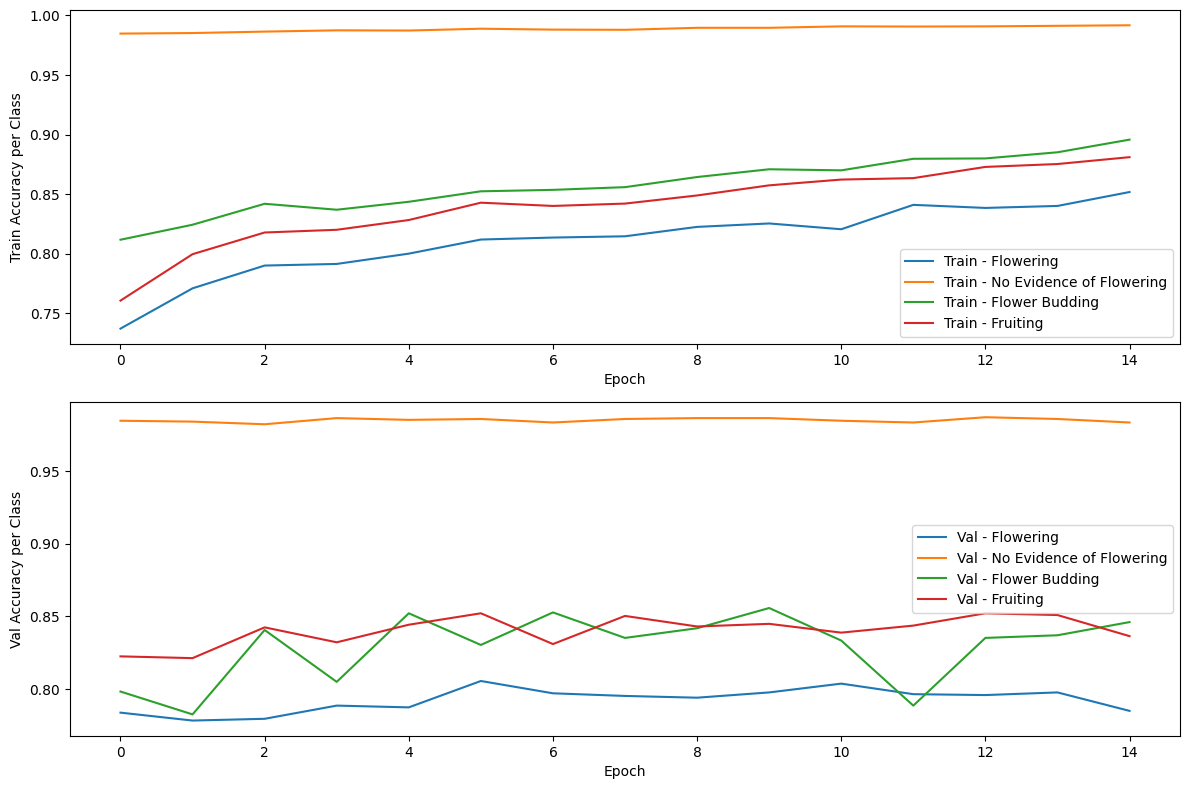

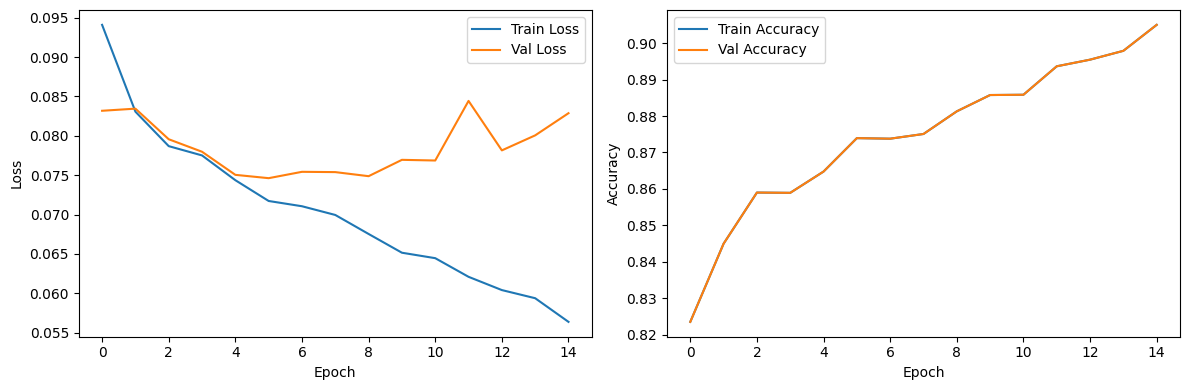

                          precision    recall  f1-score   support

               Flowering       0.70      0.83      0.76       680
No Evidence of Flowering       0.43      0.24      0.31        25
          Flower Budding       0.68      0.51      0.58       349
                Fruiting       0.79      0.75      0.77       596

               micro avg       0.73      0.73      0.73      1650
               macro avg       0.65      0.58      0.61      1650
            weighted avg       0.72      0.73      0.72      1650
             samples avg       0.73      0.73      0.73      1650



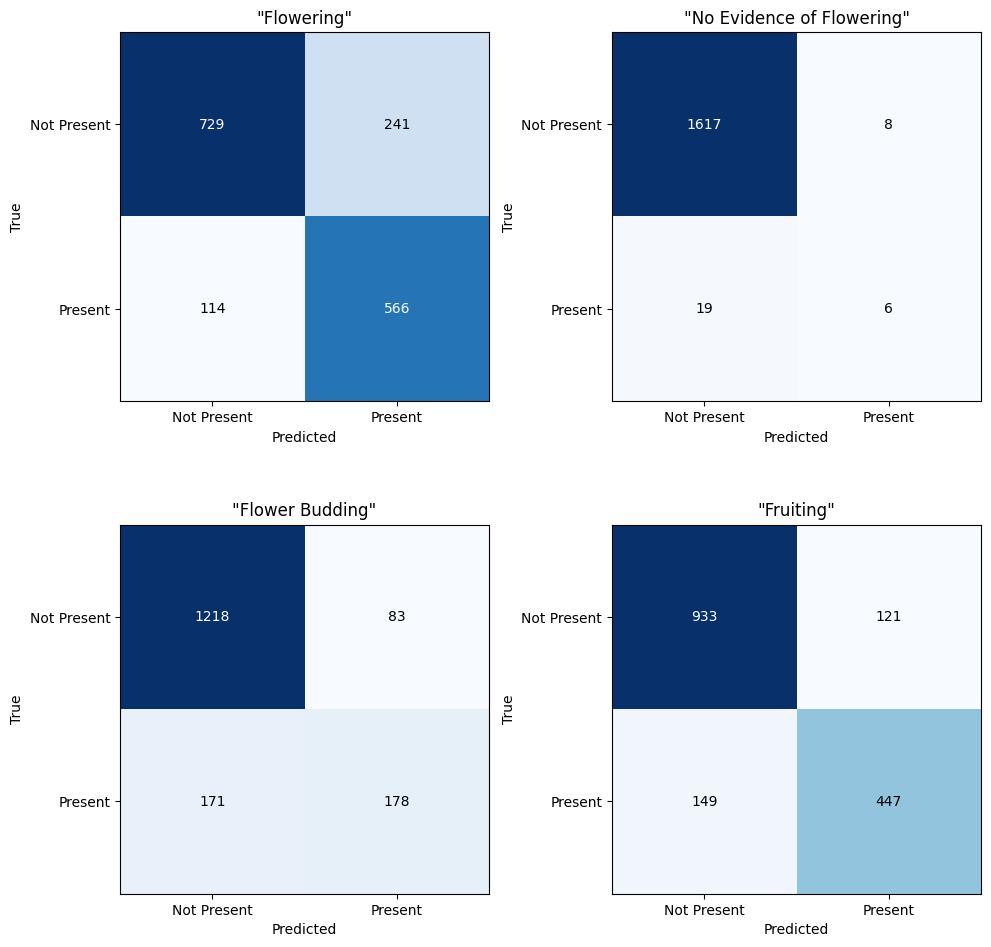

Successfully updated phenology data!
Total process time:63.30 seconds


In [12]:
create_model_and_predict('complete_dactylis_glomerata_n_a')

Download data from github...
remote: Enumerating objects: 111439, done.
remote: Counting objects: 100% (324/324), done.
remote: Compressing objects: 100% (318/318), done.
remote: Total 111439 (delta 301), reused 7 (delta 6), pack-reused 111115 (from 2)
Receiving objects: 100% (111439/111439), 737.21 MiB | 15.59 MiB/s, done.
Resolving deltas: 100% (392/392), done.
Updating files: 100% (111753/111753), done.
Already on 'main'
Your branch is up to date with 'origin/main'.
Using device: cuda
Total observations: 79498
Labeled observations: 9257
Unlabeled observations: 70241
Training set size: 7405
Validation set size: 1852


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 226MB/s]


Epoch 1/15: Train Loss: 0.0486, Validation Loss: 0.0458
Epoch 2/15: Train Loss: 0.0413, Validation Loss: 0.0450
Epoch 3/15: Train Loss: 0.0402, Validation Loss: 0.0436
Epoch 4/15: Train Loss: 0.0386, Validation Loss: 0.0422
Epoch 5/15: Train Loss: 0.0376, Validation Loss: 0.0432
Epoch 6/15: Train Loss: 0.0375, Validation Loss: 0.0428
Epoch 7/15: Train Loss: 0.0360, Validation Loss: 0.0446
Epoch 8/15: Train Loss: 0.0350, Validation Loss: 0.0446
Epoch 9/15: Train Loss: 0.0343, Validation Loss: 0.0436
Epoch 10/15: Train Loss: 0.0335, Validation Loss: 0.0470
Epoch 11/15: Train Loss: 0.0336, Validation Loss: 0.0446
Epoch 12/15: Train Loss: 0.0327, Validation Loss: 0.0453
Epoch 13/15: Train Loss: 0.0320, Validation Loss: 0.0460
Epoch 14/15: Train Loss: 0.0315, Validation Loss: 0.0484
Epoch 15/15: Train Loss: 0.0302, Validation Loss: 0.0492


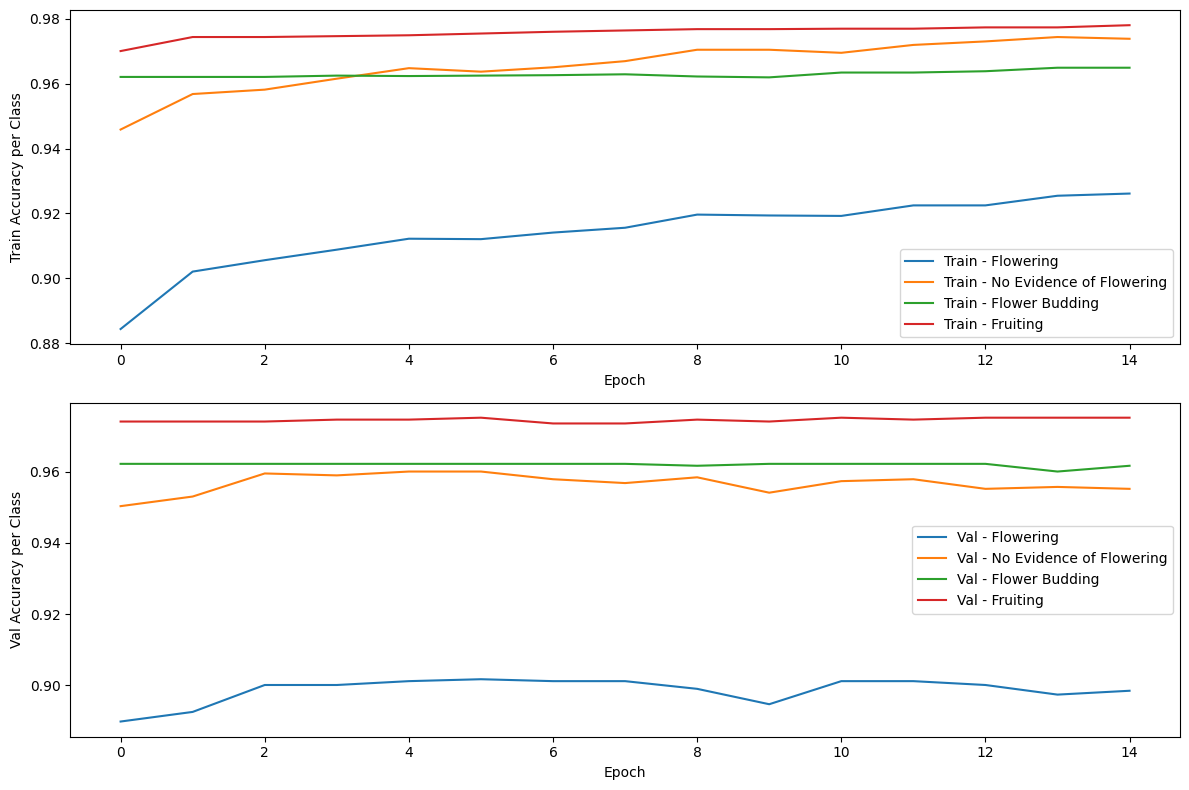

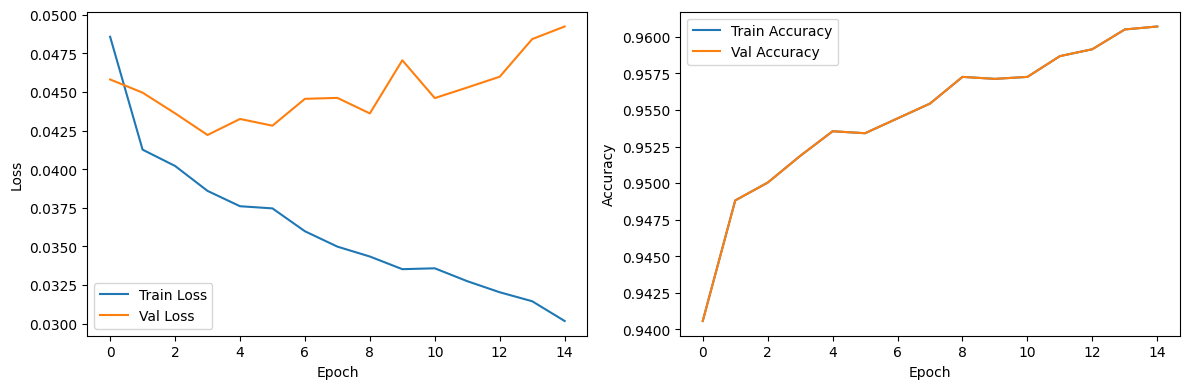

                          precision    recall  f1-score   support

               Flowering       0.92      0.97      0.94      1619
No Evidence of Flowering       0.62      0.70      0.66       115
          Flower Budding       0.00      0.00      0.00        70
                Fruiting       0.75      0.06      0.12        48

               micro avg       0.90      0.90      0.90      1852
               macro avg       0.57      0.43      0.43      1852
            weighted avg       0.86      0.90      0.87      1852
             samples avg       0.90      0.90      0.90      1852



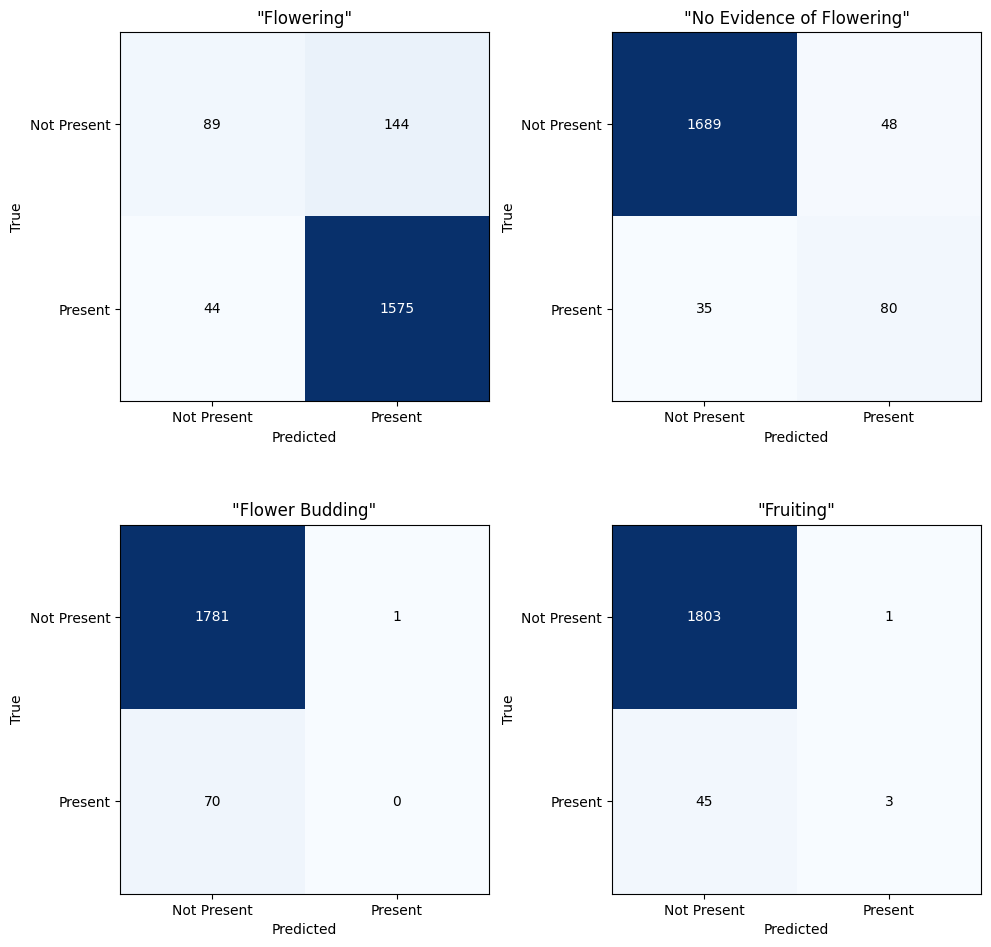

Successfully updated phenology data!
Total process time:263.44 seconds


In [10]:
create_model_and_predict('complete_trifolium_pratense_n_a')